# *Лабораторная работа №1*

## Построение бинарного классификатора (Теоретическая часть)

Мы продолжаем работу над датасетом с данными о проданных подержанных автомобилях в Германии в 2016 году (см. https://colab.research.google.com/drive/1fl7f7-8WA5GIjZ6qghfiD_2sEaCc1DQH?usp=sharing). В рамках текущей лабораторной необходимо построить модель бинарного классификатора, который бы позволил определить была ли машина в ремонте или нет.


Подключим все необходимые для дальнейшей работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

import warnings
warnings.filterwarnings("ignore")

Загрузим базу данных, которая была получена нами в ходе предыдущей работы, т.е. в ней уже проведена определенная работа по очистке данных (подробнее см. лаб1).

In [2]:
%%capture
!wget https://www.dropbox.com/s/s1sqfsi6x7hbs28/autos_mod.csv

Записываем ее в датафрейм и проверим столбцы на наличие пустых значений.

In [3]:
df = pd.read_csv('autos_mod.csv', encoding='iso-8859-1')
df.isnull().any()

,0
Unnamed: 0,False
price,False
vehicleType,True
yearOfRegistration,False
gearbox,True
powerPS,False
model,True
kilometer,False
fuelType,True
brand,False


Удалим столбец, который возник в процессе переписывания набора данных, так как никакой полезной информации он не несет.

In [4]:
del df["Unnamed: 0"]

Воспользуемся самым ленивым способом восстановления данных и очистим все столбцы от пустых значений, чтобы работать с исключительно неповрежденными записями.

In [5]:
df = df.drop(df[pd.isnull(df['vehicleType'])].index)
df = df.drop(df[pd.isnull(df['gearbox'])].index)
df = df.drop(df[pd.isnull(df['model'])].index)
df = df.drop(df[pd.isnull(df['fuelType'])].index)
df = df.drop(df[pd.isnull(df['notRepairedDamage'])].index)

Проверим, что у нас не осталось записей с пустыми значениями.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250919 entries, 2 to 329656
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               250919 non-null  int64 
 1   vehicleType         250919 non-null  object
 2   yearOfRegistration  250919 non-null  int64 
 3   gearbox             250919 non-null  object
 4   powerPS             250919 non-null  int64 
 5   model               250919 non-null  object
 6   kilometer           250919 non-null  int64 
 7   fuelType            250919 non-null  object
 8   brand               250919 non-null  object
 9   notRepairedDamage   250919 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


В нашем наборе данных достаточно большое количество полей типа object. Для того, чтобы с ними можно было работать, необходимо провести факторизацию, но сначала рассмотрим эти значения.

In [7]:
df['vehicleType'].unique()

array(['kleinwagen', 'limousine', 'cabrio', 'kombi', 'suv', 'bus',
       'coupe', 'andere'], dtype=object)

In [8]:
df['gearbox'].unique()

array(['manuell', 'automatik'], dtype=object)

In [9]:
df['model'].unique()

array(['golf', 'fabia', '3er', '2_reihe', 'andere', '3_reihe', 'passat',
       'navara', 'twingo', 'c_max', 'a_klasse', 'scirocco', '5er',
       'arosa', 'civic', 'transporter', 'punto', 'e_klasse', 'one',
       'clio', '1er', 'b_klasse', 'fortwo', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'scenic', 'a1', 'focus', 'tt', 'astra', 'a6', 'jazz',
       'polo', 'slk', '7er', 'combo', '80', '147', 'glk', 'meriva',
       'z_reihe', 'ibiza', 'mustang', 'eos', 'a4', 'touran', 'getz',
       'insignia', 'megane', 'a3', 'lupo', 'r19', 'colt', 'corsa',
       'vectra', 'berlingo', 'm_klasse', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', 'mondeo', '6er', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'omega', 'cuore',
       's_max', 'modus', 'a2', 'x_reihe', 'a5', 'galaxy', 'c3', 'viano',
       's_klasse', 'sharan',

In [10]:
df['fuelType'].unique()

array(['benzin', 'diesel', 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

In [11]:
df['notRepairedDamage'].unique()

array(['nein', 'ja'], dtype=object)

Для поля, которое нас интересует больше всего проверим соотношение количества записей, относящихся к разным классам.

In [12]:
df['notRepairedDamage'].value_counts()

,count
notRepairedDamage,
nein,225322
ja,25597


Отношение 1 к 10 не является хорошим, так как обеспечивает перевес объектов одного класса. Данный момент можно попытаться обойти, уравновесив выборки по принадлежности к классам. В рамках данной методички продолжим обучение на необработанной выборке.

Проведем факторизацию и проверим результат ее исполнения.

In [13]:
names = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for name in names:
    df[name] = pd.factorize(df[name])[0]
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
2,1500,0,2001,0,75,0,150000,0,0,0
3,3600,0,2008,0,69,1,90000,1,1,0
4,650,1,1995,0,102,2,150000,0,2,1
5,2200,2,2004,0,109,3,150000,0,3,0
6,0,1,1980,0,50,4,40000,0,0,0


Как мы можем видеть, в результате удаления части значений из базы данных, произошло нарушение следования индексов. В рамках нашей задачи данный аспект некритичен, но все же произведемсброс индексации.

In [14]:
df = df.reset_index(drop=True)
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,1500,0,2001,0,75,0,150000,0,0,0
1,3600,0,2008,0,69,1,90000,1,1,0
2,650,1,1995,0,102,2,150000,0,2,1
3,2200,2,2004,0,109,3,150000,0,3,0
4,0,1,1980,0,50,4,40000,0,0,0


Проверим, как стали выглядеть исследуемые классы после факторизации.

In [15]:
df['notRepairedDamage'].value_counts()

,count
notRepairedDamage,
0,225322
1,25597


Разобьем весь наш набора данных на тренировочный и тестовый наборы данных.


*Вопрос на подумать:* Какое разбиение можно считать удачным при работе с подобным набором данных?

In [16]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

Создадим достаточно простенькую модель из 10 решающих деревьев и оценим точность ее работы.

In [ ]:
rf_model = ensemble.RandomForestClassifier(n_estimators=10)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9021002710027101


С одной стороны, точность работы классификатора, близкая к 90% - хороший показатель. С другой стороны, не будем забывать о том, что распределение классов в нашем датасете неравномерное. Поэтому проведем сравнение с константным классификатором.

In [18]:
print(accuracy_score(test_values, np.zeros_like(test_values)))

0.9007452574525745


Классификатор, который абсолютно все объекты относит к одному и тому же классу, работает с сопоставимой точностью. В этом и состоит основная сложность работы с несбалансированными наборами данных. Попробуем увеличить количество деревьев в модели.

In [19]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9048900047824008


Увеличение количества деревьев привело к улучшению результата, но от идеала он по-прежнему далек. В качестве альтернативы попробуем использовать аппарат искусственных нейронных сетей.

In [20]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 1000,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8079 - loss: 128.6097 - val_accuracy: 0.9004 - val_loss: 13.1049
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8315 - loss: 50.9222 - val_accuracy: 0.9002 - val_loss: 16.5077
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8347 - loss: 13.6321 - val_accuracy: 0.8705 - val_loss: 21.3685
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8330 - loss: 20.6553 - val_accuracy: 0.9007 - val_loss: 12.3147
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8379 - loss: 12.9106 - val_accuracy: 0.8979 - val_loss: 24.3193
Test-Accuracy: 0.8354646563529968


Данная модель демонстрирует крайнюю неустойчивость, так как при каждом запуске значение точности сильно разнится. Если мы уменьшим количество записей, обрабатываемых между корректировкой весов, то сможем получить более стабильный результат.

In [21]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7942 - loss: 408.5898 - val_accuracy: 0.8984 - val_loss: 5.4334
Epoch 2/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8450 - loss: 45.7881 - val_accuracy: 0.8637 - val_loss: 23.2416
Epoch 3/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8171 - loss: 86.8012 - val_accuracy: 0.8876 - val_loss: 4.3586
Epoch 4/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8390 - loss: 112.2983 - val_accuracy: 0.8978 - val_loss: 1.6861
Epoch 5/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8277 - loss: 4.3607 - val_accuracy: 0.9000 - val_loss: 4.4287
Test-Accuracy: 0.835360050201416


Для окончательного закрепления результата увеличим количество эпох обучения до 10, чтобы кривая обучения успевала сходиться.

In [22]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8243 - loss: 143.9112 - val_accuracy: 0.8983 - val_loss: 2.9921
Epoch 2/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8310 - loss: 36.2172 - val_accuracy: 0.9007 - val_loss: 1.9176
Epoch 3/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8368 - loss: 11.6808 - val_accuracy: 0.9007 - val_loss: 3.5600
Epoch 4/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8392 - loss: 3.4365 - val_accuracy: 0.8943 - val_loss: 30.3945
Epoch 5/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8876 - loss: 11.5601 - val_accuracy: 0.8584 - val_loss: 0.4262
Epoch 6/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8874 - loss: 19.2114 - val_accuracy: 0.9007 - val_loss: 0.3687
Epoch 7/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8976 - loss: 7.0220 - val_accuracy: 0.9007 - val_loss: 0.3496
Epoch 8/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8970 - loss: 

Попробуем ввести дополнительный скрытый слой в сеть, чтобы упростить задачу классификации выходному слою нейронов.

In [23]:
model = models.Sequential()

model.add(layers.Dense(10, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7931 - loss: 198.9348 - val_accuracy: 0.8986 - val_loss: 1.5993
Epoch 2/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8399 - loss: 27.7849 - val_accuracy: 0.8993 - val_loss: 4.1491
Epoch 3/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8385 - loss: 7.6395 - val_accuracy: 0.9001 - val_loss: 2.8067
Epoch 4/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8379 - loss: 3.0901 - val_accuracy: 0.8941 - val_loss: 0.5924
Epoch 5/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8337 - loss: 3.2505 - val_accuracy: 0.8992 - val_loss: 1.2410
Epoch 6/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8366 - loss: 2.6228 - val_accuracy: 0.9000 - val_loss: 1.3574
Epoch 7/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8337 - loss: 2.4559 - val_accuracy: 0.6157 - val_loss: 1.3575
Epoch 8/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8320 - loss: 2.

Благодаря уменьшению количества нейронов на предпоследнем слое, нейронная сеть смогла с большей точностью определять ключевые компоненты и учитывать их при вынесении вердикта о принадлежности объекта тому или иному классу.

Кроме работы непосредственно с моделями и их составляющими, можно попробовать преобразовать данные для их лучшей интерпретируемости системой. В данном случае, поле года выпуска автомобиля имеет плохую форму распределения.

<Axes: >

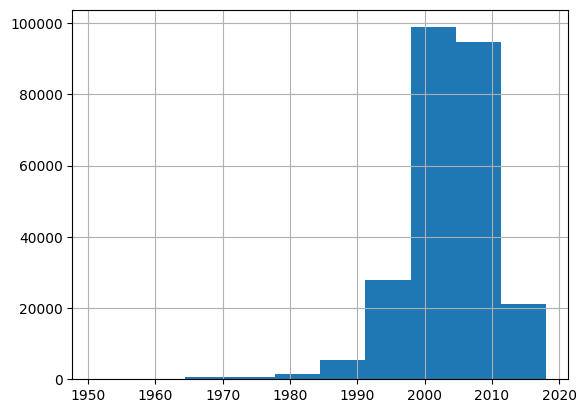

In [81]:
df['yearOfRegistration'].hist()

Введем вместо него поле с возрастом.

In [82]:
df['age'] = 2020 - df['yearOfRegistration']
del df['yearOfRegistration']
df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
0,1500,0,0,75,0,150000,0,0,0,19
1,3600,0,0,69,1,90000,1,1,0,12
2,650,1,0,102,2,150000,0,2,1,25
3,2200,2,0,109,3,150000,0,3,0,16
4,0,1,0,50,4,40000,0,0,0,40


In [83]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [84]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9040331579786386


In [85]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8326 - loss: 73.0144 - val_accuracy: 0.8961 - val_loss: 44.4679
Epoch 2/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8319 - loss: 13.8584 - val_accuracy: 0.8961 - val_loss: 70.5837
Epoch 3/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8334 - loss: 10.2520 - val_accuracy: 0.8962 - val_loss: 98.1911
Epoch 4/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8321 - loss: 7.5256 - val_accuracy: 0.6030 - val_loss: 15.5008
Epoch 5/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8310 - loss: 5.1677 - val_accuracy: 0.8919 - val_loss: 23.9337
Epoch 6/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8388 - loss: 2.4520 - val_accuracy: 0.8962 - val_loss: 13.6072
Epoch 7/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8393 - loss: 1.8243 - val_accuracy: 0.8890 - val_loss: 65.2012
Epoch 8/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8765 - l

Для обеих моделей мы получили увеличение точности. Попробуем пойти еще немного дальше, объединив два поля в одно. Такой подход называют уменьшением размерности, так как он позволяет работать с входным вектором меньшего размера.

In [86]:
df['intence'] = df['kilometer']/df['age']
del df['kilometer']
del df['age']

In [87]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [88]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9025984377490833


In [89]:
model = models.Sequential()

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8045 - loss: 31.0766 - val_accuracy: 0.8955 - val_loss: 0.5835
Epoch 2/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8481 - loss: 6.3717 - val_accuracy: 0.8968 - val_loss: 0.7634
Epoch 3/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8502 - loss: 16.7091 - val_accuracy: 0.8951 - val_loss: 1.4587
Epoch 4/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8570 - loss: 8.3101 - val_accuracy: 0.7708 - val_loss: 3.0389
Epoch 5/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8484 - loss: 49.7620 - val_accuracy: 0.8955 - val_loss: 0.4785
Epoch 6/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8476 - loss: 14.3267 - val_accuracy: 0.8970 - val_loss: 0.9552
Epoch 7/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8551 - loss: 12.9841 - val_accuracy: 0.8806 - val_loss: 7.0372
Epoch 8/10
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8476 - loss: 4

Уменьшение размерности нашего входного вектора не привело к улучшению общей картины. Не всегда одни и те же шаги приводят к одному и тому же результату. Из-за специфики датасета действенность метода может очень сильно варьироваться.

## Построение бинарного классификатора (Практическая часть)

Вашим заданием в данной лабораторной будет построение бинарного классификатора для предсказания возможного ухода клиента из банка. Задание основано на следующем датасете https://www.kaggle.com/datasets/willianoliveiragibin/bank-churn-prediction?resource=download.

Ниже приведены инструкции для загрузки тренировочной  (разделение ее на обучающую и тестовую части остается на усмотрение исполнителя) и валидационной части датасета. Валидационная часть не участвует в обучении, только в получении итоговой оценки.

In [90]:
%%capture
!wget -O bank_train.csv https://www.dropbox.com/scl/fi/rz8xmydm1h3bpgjjm30jd/bank_train.csv?rlkey=rylj5xs1icbfokyabtnqo5gdv&dl=0
!wget -O bank_valid.csv https://www.dropbox.com/scl/fi/05p2v6pw76tjf7c21rcyb/bank_valid.csv?rlkey=ifbgda9mj7ybbgl2txnzjq9g1&dl=0

Оценка полученного решения складывается из двух факторов:

1. Значение метрики Accuracy.
2. Общее время, которое потребовалось модели для предсказания всех меток из валидационного датасета.